# INN Hotels Project

## Context

A significant number of hotel bookings are called-off due to cancellations or no-shows. The typical reasons for cancellations include change of plans, scheduling conflicts, etc. This is often made easier by the option to do so free of charge or preferably at a low cost which is beneficial to hotel guests but it is a less desirable and possibly revenue-diminishing factor for hotels to deal with. Such losses are particularly high on last-minute cancellations. 

The new technologies involving online booking channels have dramatically changed customers’ booking possibilities and behavior. This adds a further dimension to the challenge of how hotels handle cancellations, which are no longer limited to traditional booking and guest characteristics. 

The cancellation of bookings impact a hotel on various fronts:
* Loss of resources (revenue) when the hotel cannot resell the room.
* Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms.
* Lowering prices last minute, so the hotel can resell a room, resulting in reducing the profit margin.
* Human resources to make arrangements for the guests.

## Objective
The increasing number of cancellations calls for a Machine Learning based solution that can help in predicting which booking is likely to be canceled. INN Hotels Group has a chain of hotels in Portugal, they are facing problems with the high number of booking cancellations and have reached out to your firm for data-driven solutions. You as a data scientist have to analyze the data provided to find which factors have a high influence on booking cancellations, build a predictive model that can predict which booking is going to be canceled in advance, and help in formulating profitable policies for cancellations and refunds.

## Data Description
The data contains the different attributes of customers' booking details. The detailed data dictionary is given below.


**Data Dictionary**

* Booking_ID: unique identifier of each booking
* no_of_adults: Number of adults
* no_of_children: Number of Children
* no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
* no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
* type_of_meal_plan: Type of meal plan booked by the customer:
    * Not Selected – No meal plan selected
    * Meal Plan 1 – Breakfast
    * Meal Plan 2 – Half board (breakfast and one other meal)
    * Meal Plan 3 – Full board (breakfast, lunch, and dinner)
* required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
* room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
* lead_time: Number of days between the date of booking and the arrival date
* arrival_year: Year of arrival date
* arrival_month: Month of arrival date
* arrival_date: Date of the month
* market_segment_type: Market segment designation.
* repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
* no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
* no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
* avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
* no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
* booking_status: Flag indicating if the booking was canceled or not.

## Importing necessary libraries and data

In [3]:
# import libraries for data manipulation
import numpy as np
import pandas as pd

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# split the data into train and test
from sklearn.model_selection import train_test_split

# to build linear regression_model
from sklearn.linear_model import LinearRegression

# to check model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# to build linear regression_model using statsmodels
import statsmodels.api as sm

# to compute VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram



# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()    




# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf




def checking_vif(predictors):
  vif = pd.DataFrame()
  vif["feature"] = predictors.columns
  vif["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(len(predictors.columns))]
  return vif.sort_values(by="VIF", ascending=False)

def treating_multicollinearity(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance (adj. R-squared and RMSE)

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    # empty lists to store adj. R-squared and RMSE values
    adj_r2 = []
    rmse = []

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp      


def treating_multicollinearity_logitR(predictors, target, high_vif_columns):
    """
    Checking the effect of dropping the columns showing high multicollinearity
    on model performance

    predictors: independent variables
    target: dependent variable
    high_vif_columns: columns having high VIF
    """
    

    # build ols models by dropping one of the high VIF columns at a time
    # store the adjusted R-squared and RMSE in the lists defined previously
    for cols in high_vif_columns:
        # defining the new train set
        train = predictors.loc[:, ~predictors.columns.str.startswith(cols)]

        # create the model
        olsmodel = sm.OLS(target, train).fit()

        # adding adj. R-squared and RMSE to the lists
        adj_r2.append(olsmodel.rsquared_adj)
        rmse.append(np.sqrt(olsmodel.mse_resid))

    # creating a dataframe for the results
    temp = pd.DataFrame(
        {
            "col": high_vif_columns,
            "Adj. R-squared after_dropping col": adj_r2,
            "RMSE after dropping col": rmse,
        }
    ).sort_values(by="Adj. R-squared after_dropping col", ascending=False)
    temp.reset_index(drop=True, inplace=True)

    return temp 

# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(model, predictors, target, threshold=0.5):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf



# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


## Data Overview

- Observations
- Sanity checks

In [5]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Python Course/INNHotelsGroup.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [6]:
df['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [7]:
print('No of rows:',df.shape[0],'\n','No of cols:',df.shape[1],'\n')
print(' --------------------')
print('Data Information\n',df.info(),'\n')
print(' --------------------')
print('Data Description\n',df.describe().T,'\n')
print(' --------------------')
print('Number of Null Values\n',df.isnull().sum(),'\n')
print(' --------------------')
print('Number of duplicated values\n',df[df.duplicated()==True])

No of rows: 36275 
 No of cols: 19 

 --------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month          

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What are the busiest months in the hotel?
2. Which market segment do most of the guests come from?
3. Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?
4. What percentage of bookings are canceled? 
5. Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
6. Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?

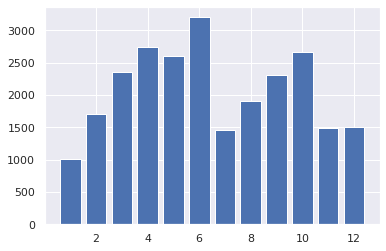

Plot shows Avg number of arrivals in a particular month 

%age of Offline market segment: 29.02274293590627 

%age of Online market segment: 63.994486560992414 

%age of Corporate market segment: 5.5603032391454175 

%age of Aviation market segment: 0.34458993797381116 

%age of Complementary market segment: 1.0778773259820813 



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


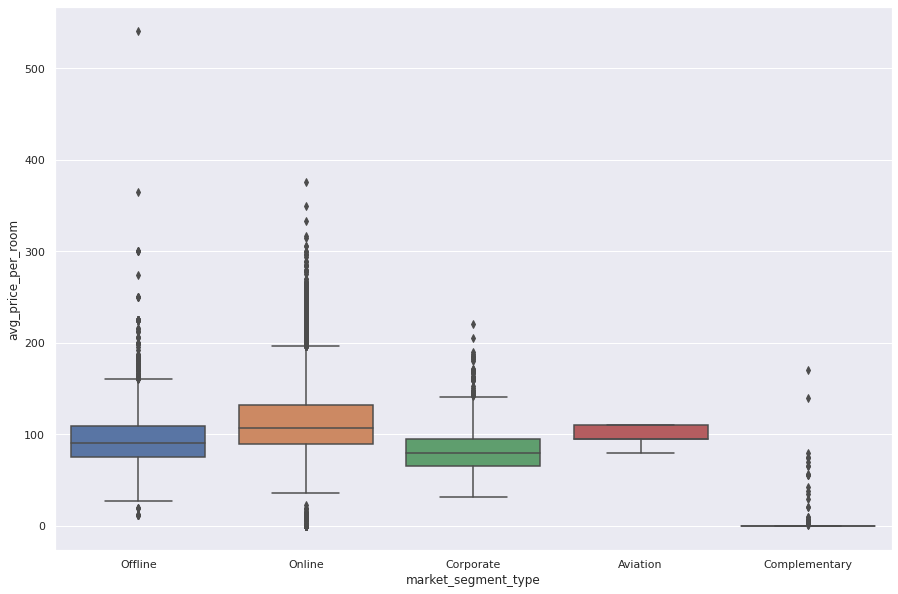

%age of cancelled bookings: 32.76361130254997 

%age of canceled bookings by repeating guests:  0.04410751206064783


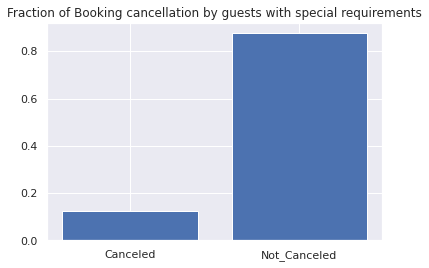

In [8]:
# What are the busiest months in the hotel?
df2=df.groupby(['arrival_month','arrival_year']).size()
busy_month=[df2[nn].mean() for nn in range(1,13)]   ####### Calculating average number of arrivals in a particular month
aa=sorted(list(df['arrival_month'].unique())) ######## list of all months with arrivals
plt.bar(aa,busy_month)
plt.show()

print('Plot shows Avg number of arrivals in a particular month','\n')


# Which market segment do most of the guests come from?
seg_type=df['market_segment_type'].unique()
for sg in seg_type: 
  print('%age of {} market segment:'.format(sg),(df[df['market_segment_type']==sg].shape[0]/df.shape[0])*100,'\n')


# Hotel rates are dynamic and change according to demand and customer demographics. What are the differences in room prices in different market segments?

plt.figure(figsize=(15, 10))

sns.boxplot(df['market_segment_type'],df['avg_price_per_room'])
plt.show()

# What percentage of bookings are canceled?
print('%age of cancelled bookings:',(df[df['booking_status']=='Canceled'].shape[0]/df.shape[0])*100,'\n')

# # Repeating guests are the guests who stay in the hotel often and are important to brand equity. What percentage of repeating guests cancel?
print('%age of canceled bookings by repeating guests: ', (df[(df['repeated_guest']==1) & (df['booking_status']=='Canceled')].shape[0]/df.shape[0])*100)

# Many guests have special requirements when booking a hotel room. Do these requirements affect booking cancellation?
# plt.figure(figsize=(15, 7))
df2=df[df['no_of_special_requests']>1]
df2.groupby(['booking_status']).size()
plt.title('Fraction of Booking cancellation by guests with special requirements')
plt.bar(df2.groupby(['booking_status']).size().index,df2.groupby(['booking_status']).size()/df2.shape[0])
plt.show()



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


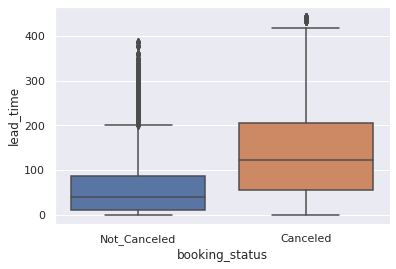

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


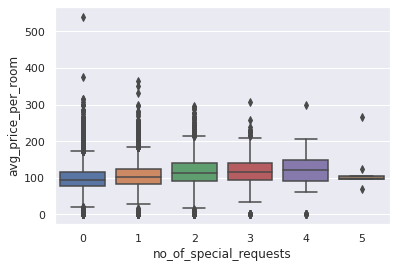

In [9]:
sns.boxplot(df['booking_status'],df['lead_time'])
plt.show()
sns.boxplot(df['no_of_special_requests'],df['avg_price_per_room'],)
plt.show()

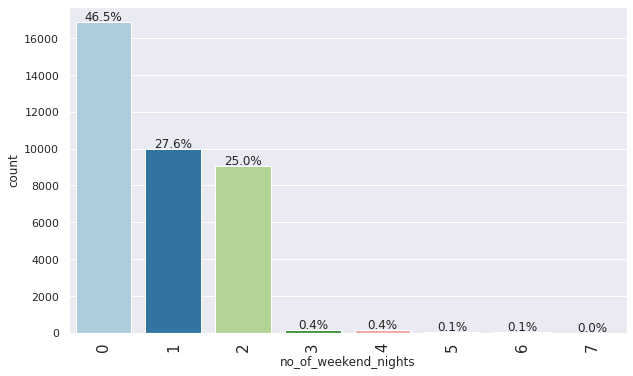

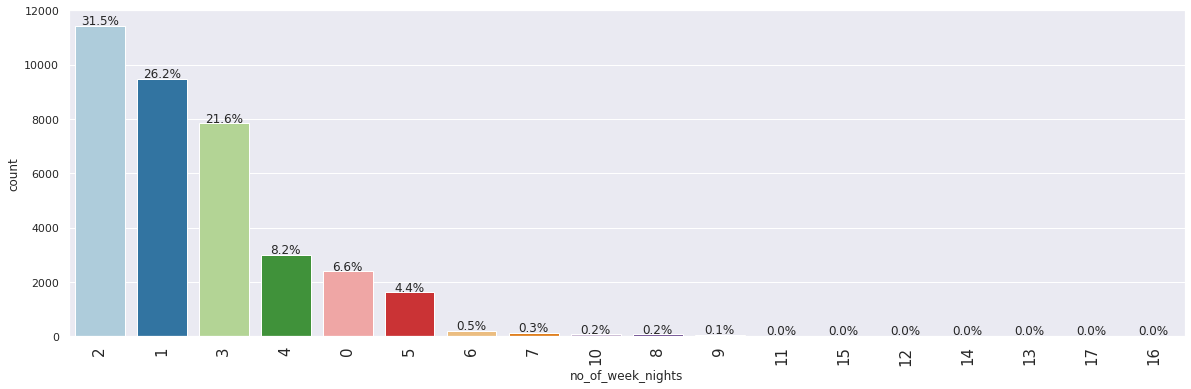

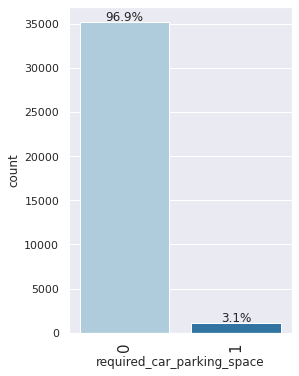

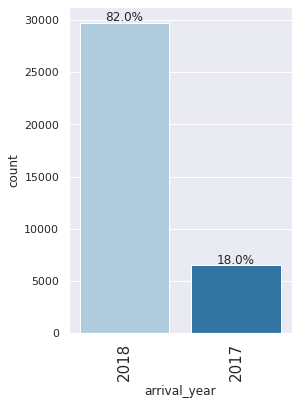

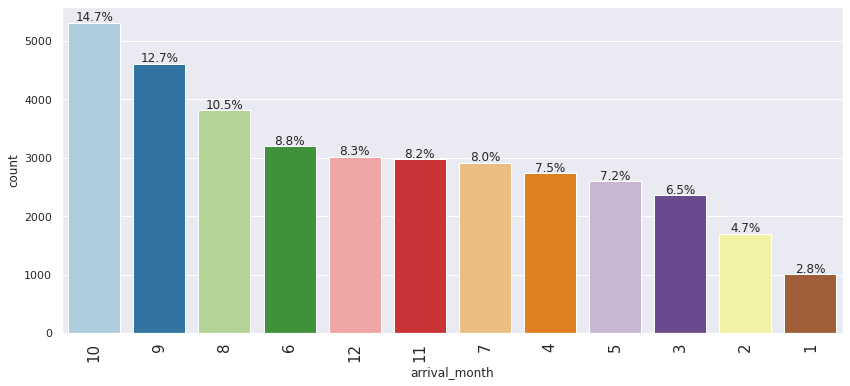

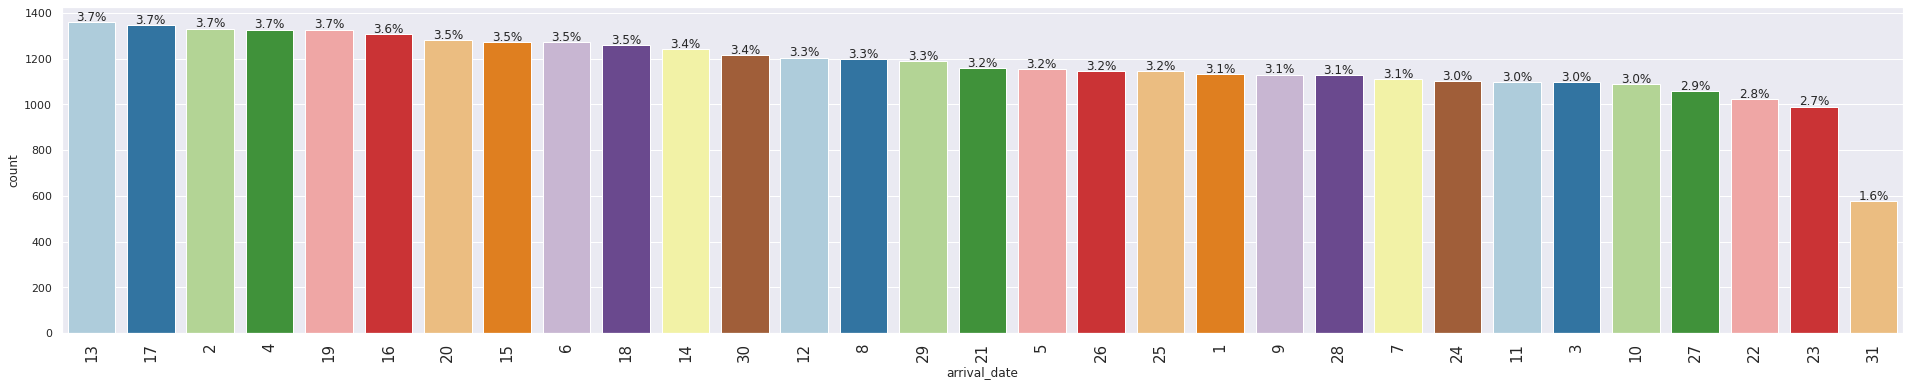

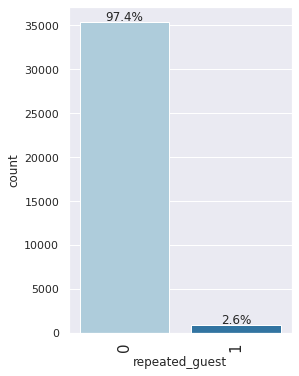

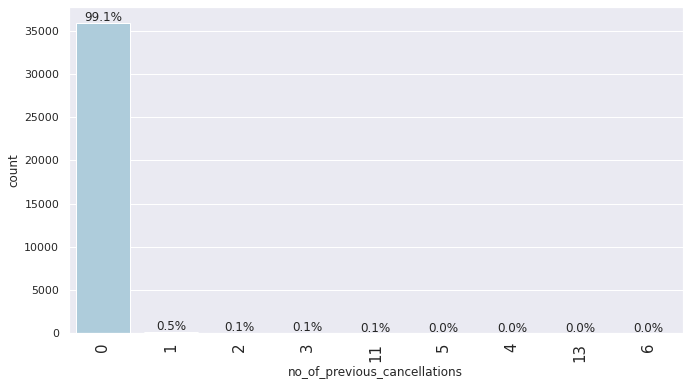

In [10]:
labeled_barplot(df, "no_of_weekend_nights", perc=True)
labeled_barplot(df, "no_of_week_nights", perc=True)
labeled_barplot(df, "required_car_parking_space", perc=True)
labeled_barplot(df,  "arrival_year", perc=True)
labeled_barplot(df,  "arrival_month", perc=True)
labeled_barplot(df, "arrival_date", perc=True)
labeled_barplot(df, "repeated_guest", perc=True)
labeled_barplot(df,  "no_of_previous_cancellations", perc=True)




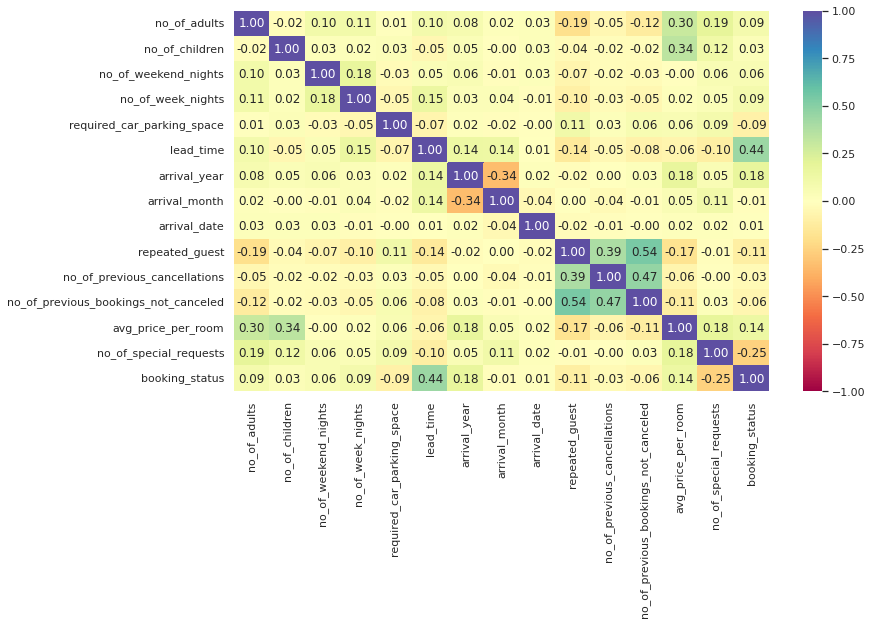

In [11]:
df["booking_status"] = df["booking_status"].apply(lambda x: 1 if x == "Canceled" else 0)

plt.figure(figsize=(12, 7))
sns.heatmap(df[list(df.columns)].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()



booking_status      0      1    All
arrival_month                      
All             24390  11885  36275
10               3437   1880   5317
9                3073   1538   4611
8                2325   1488   3813
7                1606   1314   2920
6                1912   1291   3203
4                1741    995   2736
5                1650    948   2598
11               2105    875   2980
3                1658    700   2358
2                1274    430   1704
12               2619    402   3021
1                 990     24   1014
------------------------------------------------------------------------------------------------------------------------


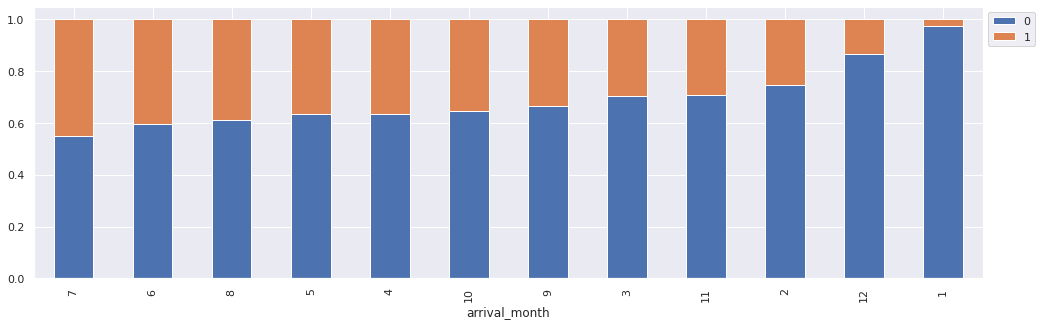

In [12]:
stacked_barplot(df, "arrival_month", "booking_status")



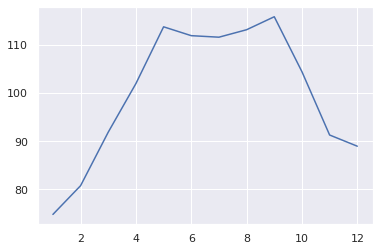

In [13]:
plt.plot(df.groupby(['arrival_month'])['avg_price_per_room'].mean())

booking_status           0      1    All
market_segment_type                     
All                  24390  11885  36275
Online               14739   8475  23214
Offline               7375   3153  10528
Corporate             1797    220   2017
Aviation                88     37    125
Complementary          391      0    391
------------------------------------------------------------------------------------------------------------------------


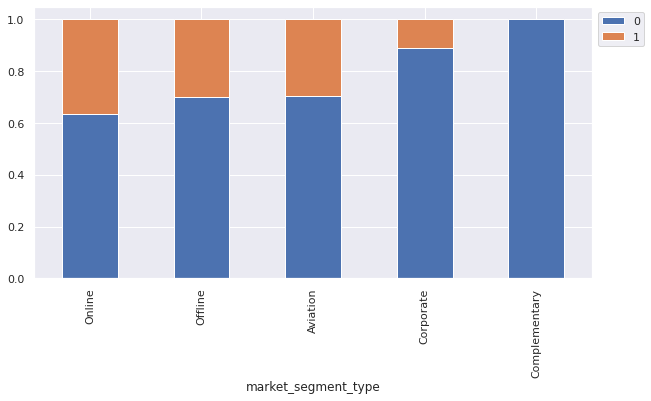

In [14]:
stacked_barplot(df, "market_segment_type", "booking_status")


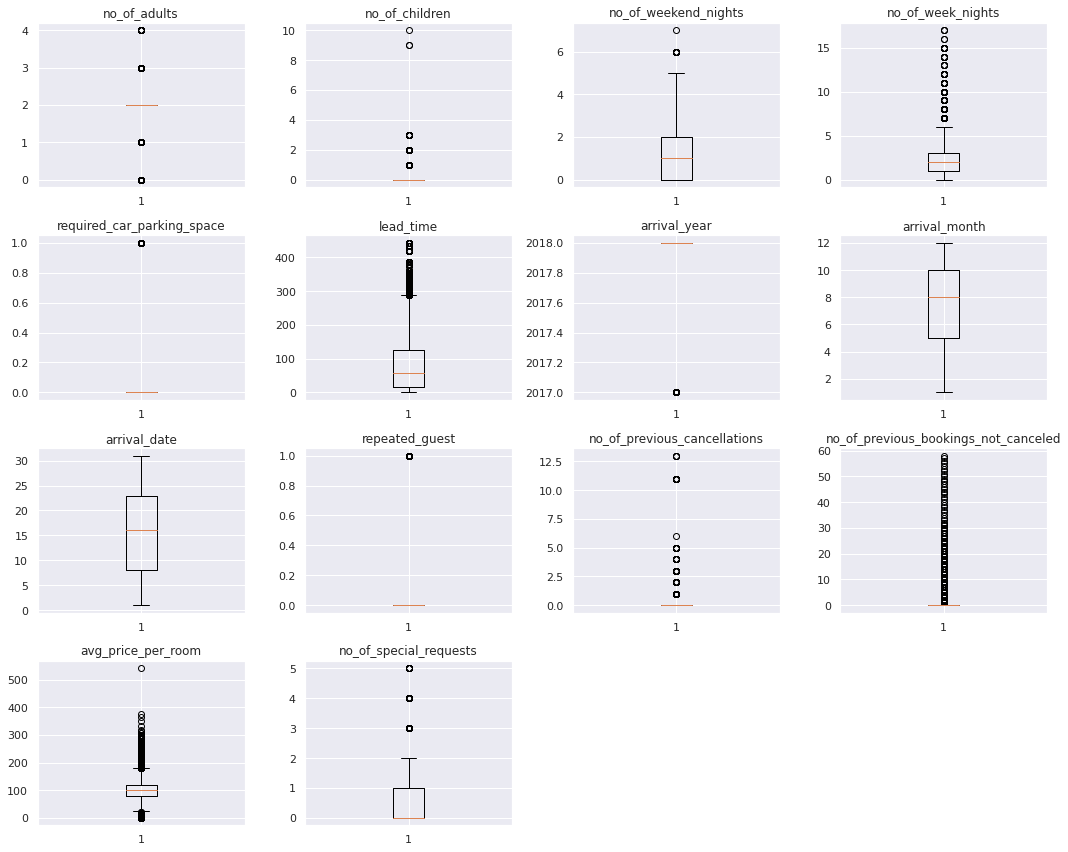

In [15]:
# outlier detection using boxplot
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
# dropping booking_status
numeric_columns.remove("booking_status")

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

# Data Preparation for modelling

In [49]:
X = df.drop(["Booking_ID","booking_status"], axis=1)
Y = df["booking_status"]
X = pd.get_dummies(X,drop_first=True) 
# adding constant
X = sm.add_constant(X)
# # Splitting data in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1) 
X_train.shape


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


(25392, 28)

In [56]:
# fitting logistic regression model
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit() ## Complete the code to fit logistic regression

print(lg.summary()) ## Complete the code to print summary of the model

         Current function value: 0.425036
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:         booking_status   No. Observations:                25392
Model:                          Logit   Df Residuals:                    25364
Method:                           MLE   Df Model:                           27
Date:                Tue, 26 Jul 2022   Pseudo R-squ.:                  0.3293
Time:                        17:03:28   Log-Likelihood:                -10793.
converged:                      False   LL-Null:                       -16091.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                 -924.5923    120.817     -7.653      0.000   -1161.390    -687.795
no_of_adults                             0.1135      

## Checking Multicollinearity

- In order to make statistical inferences from a logistic regression model, it is important to ensure that there is no multicollinearity present in the data.

In [64]:
rmcl=checking_vif(X_train) 
col_list=rmcl['feature'][rmcl['VIF']>5]
res = treating_multicollinearity_logitR(X_train, y_train, col_list) 
print(res)


collist=['screen_size','weight','os_iOS','brand_name_Samsung']#'brand_name_Huawei','brand_name_Apple','brand_name_Others']
xx_train=x_train.copy()
xx_test=x_test.copy()
for ii in collist:
  col_to_drop = ii 
  
  x_train2 = xx_train.loc[:, ~xx_train.columns.str.startswith(col_to_drop)] 
  x_test2 = xx_test.loc[:, ~xx_test.columns.str.startswith(col_to_drop)] 
  xx_train=x_train2.copy()
  xx_test=x_test2.copy()

vif = checking_vif(x_train2)
print("VIF after dropping ", col_to_drop)
print(vif.head(10),'\n')




# # initial list of columns
# predictors = xx_train.copy()  
# cols = predictors.columns.tolist()

# # setting an initial max p-value
# max_p_value = 1

# while len(cols) > 0:
#     # defining the train set
#     x_train_aux = predictors[cols]

#     # fitting the model
#     model = sm.OLS(y_train, x_train_aux).fit()

#     # getting the p-values and the maximum p-value
#     p_values = model.pvalues
#     max_p_value = max(p_values)

#     # name of the variable with maximum p-value
#     feature_with_p_max = p_values.idxmax()

#     if max_p_value > 0.05:
#         cols.remove(feature_with_p_max)
#     else:
#         break

# selected_features = cols
# print(selected_features)


                             col  Adj. R-squared after_dropping col  \
0                          const                           0.559323   
1     market_segment_type_Online                           0.344297   
2  market_segment_type_Corporate                           0.344019   
3    market_segment_type_Offline                           0.343280   

   RMSE after dropping col  
0                 0.380972  
1                 0.380576  
2                 0.380656  
3                 0.380871  


## Building a Logistic Regression model

## Model performance evaluation

## Final Model Summary

## Building a Decision Tree model

## Do we need to prune the tree?

## Model Performance Comparison and Conclusions

## Actionable Insights and Recommendations

- What profitable policies for cancellations and refunds can the hotel adopt?
- What other recommedations would you suggest to the hotel?